# geolocation

- formulation of a solver.

- statistical simulations in order to determine sources of uncertainty

---

## formulation

<img src='schematic.jpeg' alt='Drawing' align='right' style='width: 300px;'/>

We want to find the float horizontal position $\underline{x}=(x,y)$ of an underwater float 
given a number of **known variables**:
- $\underline{x}_s^i$ : source surface float horizontal position
- $t_e^i$ : time of emission for source $i$
- $\tilde{t}_r^i$ : time of reception of the signal emitted by source $i$ by the underwater float
- $\epsilon_i$ : signal detection, $\epsilon_i=1$ (detection) or $1$ (no detection)
- $z$ : underwater float depth(perfect knowledge), not used for now

'Perfect' knowledge is assumed for known variables wich amounts to say potential errors on there
estimates may be neglected.

**Unknown variables** are:
- $\underline{x}=(x,y)$ : underwater float position
- $\delta t$ : underwater float clock offset, $\delta t = \tilde{t}_r^i - t_r^i$, where 
$t_r^i$ is the true time of reception
- $\delta \underline{x}^i$ : vector difference between source $i$ transducer position and surface float position, $\delta \underline{x}^i = \underline{x}_t^i - \underline{x}_s^i$
- $\delta c (\underline{x},\underline{x}_t^i)$ : difference between equivalent celerity defined as 
$c(\underline{x},\underline{x}_t^i) = ||\underline{x} - \underline{x}_t^i ||/(t_r^i - t_e^i)$ and its background (a priori) estimate $c_b$, $\delta c (\underline{x},\underline{x}_t^i) = c(\underline{x},\underline{x}_t^i) - c_b$.

A priori standard deviations for $\underline{x}$, $\delta t$, $\delta \underline{x}^i$, $\delta c (\underline{x},\underline{x}_t^i)$ are
assumed to be known and given by: $e_x$, $e_{\delta t}$, $e_{\delta x}$, $e_{\delta c}$.

Background (a priori) estimates for $\underline{x}$, $\delta t$, $\delta \underline{x}^i$, $\delta c (\underline{x},\underline{x}_t^i)$ may eventually be provided. We assume all are 0 for now except
for the float position $\underline{x}_b=(x=1km, y=0km)$.


We impose **hard contraints** for each source-float acoustic travel:

$$
\begin{align*}
||\underline{x} - \underline{x}_s^i - \delta \underline{x}^i || = \big (c_b + \delta c(\underline{x},\underline{x}_t^i) \big ) \times (\tilde{t}_r^i + \delta t - t_e^i),
\end{align*}
$$

The estimate of the underwater float position $\underline{\hat{x}}$ minimizes:

$$
\begin{align*}
J(\mathbf{x}, \delta t, \delta \underline{x}_i, \delta c (\underline{x},\underline{x}_t^i)) = 
||\underline{x} - \underline{x}_b||^2 /e_x^2
+ \delta t^2 / e_{\delta t}^2 
+ \sum_i \epsilon_i \times ( ||\delta \underline{x}_i||^2 / e_{\delta x}^2
+ \delta c (\underline{x},\underline{x}_t^i)^2 / e_c^2 )
\end{align*}
$$

subject to the hard constraints listed above.

The hard constraint may used to estimate $\delta c$ and plug it into the functional J:
$$
\begin{align*}
J(\mathbf{x}, \delta t, \delta \underline{x}_i) = 
||\underline{x} - \underline{x}_b||^2 /e_x^2
+ \delta t^2 / e_{\delta t}^2 
+ \sum_i \epsilon_i \times \Big \{ \frac{||\delta \underline{x}_i||^2} {e_{\delta x}^2}
+ \frac{\big [||\underline{x} - \underline{x}_s^i - \delta \underline{x}^i ||/(\tilde{t}_r^i + \delta t - t_e^i) - c_b \big ]^2} {e_c^2} \Big \}
\end{align*}
$$

We assume $\epsilon_i=1$ in all examples below for simplicity.

We have assumed simultaneous (working assumption) emission of sources.
The underwater float velocity may be added as an extra variable (future addition).

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt

from clib.geolocation import *


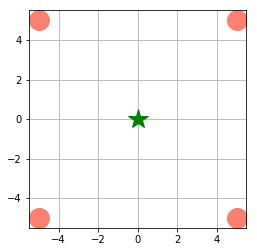

In [50]:
        
### create an ensemble of sources

# square formation:
dx=10. *1.e3 # in meters
sources=[]
sources.append(source(-dx*.5,-dx*.5))
sources.append(source(dx*.5,-dx*.5))
sources.append(source(dx*.5,dx*.5))
sources.append(source(-dx*.5,dx*.5))
#sources.append(source(0.,dx*.25))
Ns = len(sources)

### init a receiver
r=receiver(0. *1.e3, 0. *1.e3)

### plot
plt.figure()
ax=plt.subplot(111)
[s.plot() for s in sources]
r.plot()
ax.grid()
#ax.set_xlim([-1.,21.])
#ax.set_ylim([-1.,11.])
ax.set_aspect('equal')
plt.show()


In [51]:
for i, s in enumerate(sources):
    print('Distance source %d - float = %.2f km' %(i, dist(s,r)/1.e3))
    print('  horizontal offset for a sound celerity difference of %.1f m/s = %.2f m' %(10., dist(s,r)*10./1500.))

Distance source 0 - float = 7.07 km
  horizontal offset for a sound celerity difference of 10.0 m/s = 47.14 m
Distance source 1 - float = 7.07 km
  horizontal offset for a sound celerity difference of 10.0 m/s = 47.14 m
Distance source 2 - float = 7.07 km
  horizontal offset for a sound celerity difference of 10.0 m/s = 47.14 m
Distance source 3 - float = 7.07 km
  horizontal offset for a sound celerity difference of 10.0 m/s = 47.14 m


---

## Demo case



In [52]:
#[s.draw_celerity(10.) for s in sources]
#[s.draw_dxdy(10.) for s in sources]
#r.draw_clock_drift(1.)

The true underwater float position and clock offset are:

In [53]:
print('x = %.1f m \ny = %.1f m \ndt = %.1e s' %(r.x, r.y, r.dt))

x = 0.0 m 
y = 0.0 m 
dt = -7.6e-01 s


We solve the geolocation problem with the a priori uncertainties and estimates :

In [54]:
# a priori uncertainties : 
print("e_c  = %.1f m/s  (celerity)" %s.e_c)
print("e_dt = %.1f s  (clock drift)" %r.e_dt)
print("e_x  = %.1f m  (underwater float position)" %r.e_x)
#print("e_dx = %.1f m  (dx between transducer and surface float)" %s.e_dx)

e_c  = 10.0 m/s  (celerity)
e_dt = 1.0 s  (clock drift)
e_x  = 10000.0 m  (underwater float position)


In [65]:
# a priori estimates :
x0 = np.zeros((3))
# a priori position :
x0[0] = 1.e3
x0[1] = 0.e3 

In [66]:
# optimization
x_hat, y_hat, dt_hat, success, message, res = geolocalize_xydt(r, sources,x0 = x0, disp=True)

Optimization terminated successfully.
         Current function value: 1.060589
         Iterations: 32
         Function evaluations: 35
         Gradient evaluations: 35


In [67]:
# true values vs estimated by optimization
x, y, dt, dc = r.x, r.y, r.dt, [s.c - s.c_b for s in sources]

print ("True values :")
print('x = %.1fm    y = %.1fm    dt = %.1es' %(x, y, dt))

print ("\nEstimated values :")
print('x_hat=%.1fm    y_hat = %.1fm    dt_hat = %.1es' %(x_hat, y_hat, dt_hat))


True values :
x = 0.0m    y = 0.0m    dt = -7.6e-01s

Estimated values :
x_hat=-12.5m    y_hat = 37.1m    dt_hat = -7.6e-01s


## celerity statistical simulations

For each source-receiver acoustic path, a random value is drawn around **c_b = 1500m/s**.
The standard deviation of the celerity is **e_c = 10 m/s**.

In [68]:
# unchanged variables during simulations
print("s.x_t :", [s.x_t for s in sources])
print("s.y_t :", [s.y_t for s in sources])
print("s.dx  :", [s.dx for s in sources])
print("s.dy  :", [s.dy for s in sources])
print("r.dt  :", r.dt)

s.x_t : [array([-4994.49229563]), array([4999.03943211]), array([4998.61360561]), array([-5015.29838762])]
s.y_t : [array([-4983.92664746]), array([-5001.29602613]), array([5012.24754649]), array([4999.28598456])]
s.dx  : [array([5.50770437]), array([-0.96056789]), array([-1.38639439]), array([-15.29838762])]
s.dy  : [array([16.07335254]), array([-1.29602613]), array([12.24754649]), array([-0.71401544])]
r.dt  : [-0.75907367]


In [69]:
# only celerity between receiver and each source is changing
Nmc = 1000

x=np.zeros(Nmc)
y=np.zeros(Nmc)
dt=np.zeros(Nmc)

for i in range(Nmc):
    [s.draw_celerity(s.e_c) for s in sources]
    #print(i, " : s.c = ", [s.c for s in sources])
    x[i], y[i], dt[i], success, message, res = geolocalize_xydt(r, sources, disp=False)



In [72]:
d_rms = np.sqrt( np.mean( (x - r.x)**2  + (y - r.y)**2 ) )
   
# biais on the receiver position
biais_x = x.mean()-r.x
biais_y = y.mean()-r.y
biais = np.sqrt(biais_x**2 + biais_y**2)

print('RMS : %.2fm' %d_rms)
print('Biais x : %.2fm' %biais_x)
print('Biais y : %.2fm' %biais_y)
print('Biais position : %.2fm' %biais)

RMS : 44.41m
Biais x : -2.27m
Biais y : -12.65m
Biais position : 12.85m


Text(0,0.5,'y [m]')

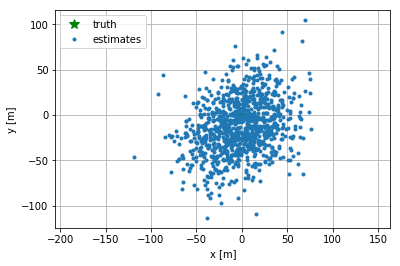

In [71]:
plt.figure()
ax=plt.subplot(111)
ax.plot(r.x,r.y,'*', color='green', markersize=10, label='truth')
ax.plot(x,y,'.', label='estimates')
ax.axis('equal')
ax.grid()
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

# Error maps

In [ ]:
### create an ensemble of sources

# square formation:
dx=10. *1.e3 # in meters
sources=[]
sources.append(source(-dx*.5,-dx*.5))
sources.append(source(dx*.5,-dx*.5))
sources.append(source(dx*.5,dx*.5))
sources.append(source(-dx*.5,dx*.5))
#sources.append(source(0.,dx*.25))
Ns = len(sources)

In [73]:
print("s.x_t :", [s.x_t for s in sources])
print("s.y_t :", [s.y_t for s in sources])
print("s.dx  :", [s.dx for s in sources])
print("s.dy  :", [s.dy for s in sources])
print("r.dt  :", r.dt)

s.x_t : [array([-5010.64435473]), array([5002.96607347]), array([4991.1309295]), array([-4999.77459935])]
s.y_t : [array([-4993.39392964]), array([-5001.08388777]), array([4981.85892305]), array([4991.47354654])]
s.dx  : [array([-10.64435473]), array([2.96607347]), array([-8.8690705]), array([0.22540065])]
s.dy  : [array([6.60607036]), array([-1.08388777]), array([-18.14107695]), array([-8.52645346])]
r.dt  : [-0.75907367]


In [74]:
# Compute now a map of errors

def simu (r, sources, Nmc, var) : 
    x=np.zeros(Nmc)
    y=np.zeros(Nmc)
    dt=np.zeros(Nmc)
    for i in range(Nmc):
        
        if var == 'celerity' : 
            [s.draw_celerity(s.e_c) for s in sources]
            
        if var == 'dxdy' : 
            [s.draw_dxdy(10.) for s in sources]
  
        if var == 'clock' : 
            r.draw_clock_drift()
            #dt_truth[i] = r.dt
            
        x[i], y[i], dt[i], success, message, res = geolocalize_xydt(r, sources, disp=False)


    # rms error on the receiver position
    d_rms = np.sqrt( np.mean( (x - r.x)**2  + (y - r.y)**2 ) )
    # biais on the receiver position
    biais_x = x.mean()-r.x
    biais_y = y.mean()-r.y
    biais = np.sqrt(biais_x**2 + biais_y**2)
    return (d_rms, biais)

In [82]:
### grid
Lx = 20.* 1.e3
Ly = Lx

xt = np.linspace(-Lx/2.,Lx/2.,20)   # affiner la grille ensuite avec 30 ou 50 valeurs
yt = np.linspace(-Ly/2.,Ly/2.,20)
Xt, Yt = np.meshgrid(xt,yt)

## Celerity

In [112]:
### number of simulations 
Nmc = 100
var = 'celerity'
### map 

RMS = np.zeros((len(xt),len(yt)))
Biais = np.zeros((len(xt),len(yt)))
for i in range (len(xt)) :
    print('i = %d/%d' %(i+1,len(xt)))
    for j in range (len(yt)):
        # init a receiver
        r = receiver(xt[i], yt[j])
        r.dt = 1. # unchanged variable during simulations 
        
        # simulations 
        d_rms, biais = simu (r, sources, Nmc, var = var) 
        RMS[i,j]   = d_rms
        Biais[i,j] = biais

i = 1/20
i = 2/20
i = 3/20
i = 4/20
i = 5/20
i = 6/20
i = 7/20
i = 8/20
i = 9/20
i = 10/20
i = 11/20
i = 12/20
i = 13/20
i = 14/20
i = 15/20
i = 16/20
i = 17/20
i = 18/20
i = 19/20
i = 20/20


In [113]:
np.save('RMS_20_20', RMS)
np.save('Biais_20_20', Biais)

In [114]:
RMS1 = np.load('RMS_20_20.npy')
Biais1 = np.load('Biais_20_20.npy')

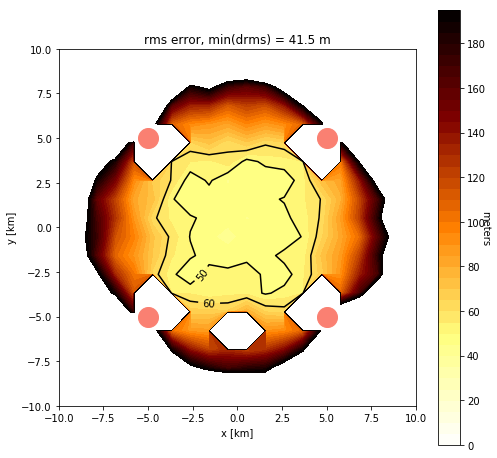

In [115]:
### plot the error map

cmap = plt.get_cmap('afmhot_r')

plt.figure(figsize=(8,8))
ax=plt.subplot(111)
lvls=np.arange(0.,2.e2,5.)
plt.contourf(Xt/1.e3,Yt/1.e3,RMS1,lvls, cmap=cmap)  #,lvls
cbar = plt.colorbar()
cbar.ax.set_ylabel('meters', rotation=270)

CS = plt.contour(Xt/1.e3,Yt/1.e3,RMS1,[50,60],colors='k')
plt.clabel(CS, [50,60],  # label every second level
           inline=1,
           fmt='%1.0f',
           fontsize=10)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('rms error, min(drms) = %.1f m' % RMS1.min())
ax.set_aspect('equal')
plt.show()

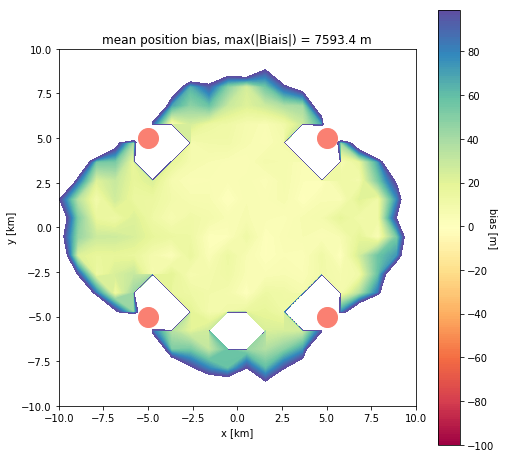

In [116]:
### bias
cmap = plt.get_cmap('Spectral')

plt.figure(figsize=(8,8))
ax=plt.subplot(111)
lvls=np.arange(-10.e1,10.e1,1.e0)
plt.contourf(Xt/1.e3,Yt/1.e3, Biais1,lvls,cmap=cmap)
cbar = plt.colorbar()
cbar.ax.set_ylabel('bias [m]', rotation=270)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('mean position bias, max(|Biais|) = %.1f m' % np.abs(Biais1).max())
ax.set_aspect('equal')
plt.show()

## dxdy

In [92]:
### number of simulations 
Nmc = 100
var = 'dxdy'
### map 

RMS = np.zeros((len(xt),len(yt)))
Biais = np.zeros((len(xt),len(yt)))
for i in range (len(xt)) :
    print('i = %d/%d' %(i+1,len(xt)))
    for j in range (len(yt)):
        # init a receiver
        r = receiver(xt[i], yt[j])
        r.dt = 1. # unchanged variable during simulations 
        # simulations 
        d_rms, biais = simu (r, sources, Nmc, var = var) 
        RMS[i,j]   = d_rms
        Biais[i,j] = biais

i = 1/20
i = 2/20
i = 3/20
i = 4/20
i = 5/20
i = 6/20
i = 7/20
i = 8/20
i = 9/20
i = 10/20
i = 11/20
i = 12/20
i = 13/20
i = 14/20
i = 15/20
i = 16/20
i = 17/20
i = 18/20
i = 19/20
i = 20/20


In [93]:
np.save('RMS_20_20_dxdy', RMS)
np.save('Biais_20_20_dxdy', Biais)

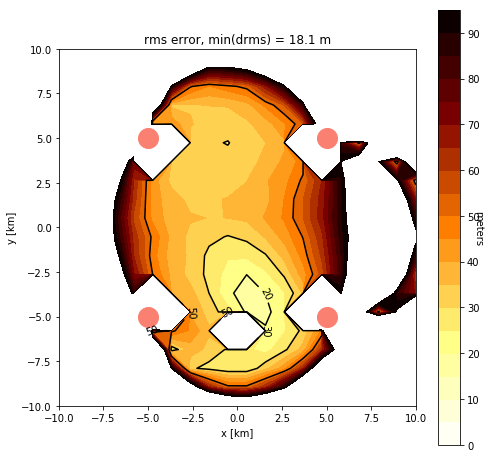

In [104]:
### plot the error map

cmap = plt.get_cmap('afmhot_r')

plt.figure(figsize=(8,8))
ax=plt.subplot(111)
lvls=np.arange(0.,1.e2,5.)
plt.contourf(Xt/1.e3,Yt/1.e3,RMS,lvls, cmap=cmap)  #,lvls
cbar = plt.colorbar()
cbar.ax.set_ylabel('meters', rotation=270)

CS = plt.contour(Xt/1.e3,Yt/1.e3,RMS,[20,30,50],colors='k')
plt.clabel(CS, [20,30,50],  # label every second level
           inline=1,
           fmt='%1.0f',
           fontsize=10)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('rms error, min(drms) = %.1f m' % RMS.min())
ax.set_aspect('equal')
plt.show()

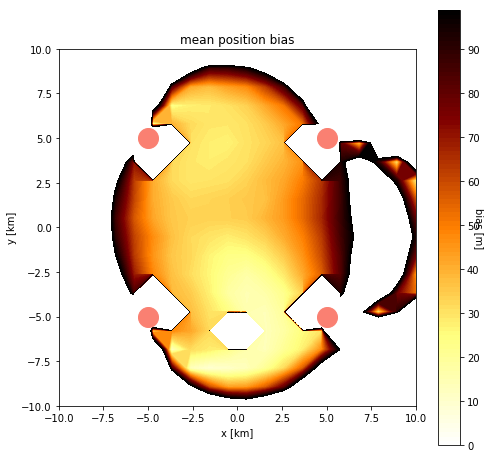

In [101]:
### bias 
#cmap = plt.get_cmap('afmhot_r')
cmap = plt.get_cmap('Spectral')

plt.figure(figsize=(8,8))
ax=plt.subplot(111)
lvls=np.arange(-10.e1,10.e1,1.e0)
plt.contourf(Xt/1.e3,Yt/1.e3, Biais,lvls,cmap=cmap)
cbar = plt.colorbar()
cbar.ax.set_ylabel('bias [m]', rotation=270)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('mean position bias')
ax.set_aspect('equal')
plt.show()